## `Importing required libraries`

In [1]:
import numpy as np
import pandas as pd

pd.set_option('max.columns', None)
import warnings
warnings.filterwarnings('ignore')

## `Implementing necessary functions`

In [2]:
def clean_df_init(link):
    df = pd.read_html(link)
    df = df[0]
    heads = list(df[df.iloc[:,8] == '90s'].index)
    df = df.drop(index = heads, axis = 0)
    df.columns = ['Rk', 'Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', 'Born', '90s', 'Gls', 'Sh', \
              'SoT', 'SoT%', 'Sh/90', 'SoT/90', 'G/Sh', 'G/SoT', 'Dist', 'FK', 'PK', 'PKatt', 'xG', 'npxG', \
             'npxG/Sh', 'G-xG', 'np:G-xG', 'Matches']
    df.drop(['Rk', 'Matches', 'Born', 'Dist', 'FK', 'PK', 'PKatt', 'xG', 'G-xG'], axis = 1, inplace = True)
    df['Comp'] = df['Comp'].str.split(' ').str[1:].str.join(' ')
    df['Nation'] = df['Nation'].str.split(' ').str[1:].str.join(' ')
    nan_age = list(df[df['Age'].isna()].index)
    df = df.drop(index = nan_age, axis = 0)
    df['Age'] = df['Age'].str[:2].astype('int32')
    df.fillna(0)
    irrel = list(df[df['Pos'].isin(['DF,FW', 'GK,MF'])].index)
    df.drop(index = irrel, inplace = True)
    d = {'DF':'Defender',
     'MF': 'Midfielder',
    'FW': 'Forward',
    'FW,MF': 'Attacking-Midfielder',
    'MF,FW': 'Attacking-Midfielder',
    'GK': 'Goalkeeper',
    'DF,MF': 'Defensive Midfielder',
    'MF,DF': 'Defensive Midfielder',
     'FW,DF': 'Forward'
    }
    df['90s'] = df['90s'].astype('float')
    df['Pos'] = df['Pos'].map(d)
    #df['Gls/90'] = df['Gls'].astype('int32').divide(df['90s'].astype('float'))
    #df['npxG/90'] = df['npxG'].astype('float').divide(df['90s'].astype('float'))
    #df['np:G-xG/90'] = df['np:G-xG'].astype('float').divide(df['90s'].astype('float'))
    #cols = ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', '90s', 'Gls/90', 'Sh/90', 'SoT/90', 'SoT%', \
          # 'npxG/90', 'np:G-xG/90']
    #df_new = df[cols]
    return df

In [3]:
def clean_df(df):
    
    
    #df['Gls/90'] = df['Gls'].astype('int32').divide(df['90s'].astype('float'))
    #df['npxG/90'] = df['npxG'].astype('float').divide(df['90s'].astype('float'))
    #df['np:G-xG/90'] = df['np:G-xG'].astype('float').divide(df['90s'].astype('float'))
    #cols = ['Player', 'Nation', 'Pos', 'Squad', 'Comp', 'Age', '90s', 'Gls/90', 'Sh/90', 'SoT/90', 'SoT%', \
         #  'npxG/90', 'np:G-xG/90']
    #df_new = df[cols]
    df_new = df.copy()
    df_new['Gls'] = df['Gls'].astype('int32')
    df_new['npxG'] = df_new['npxG'].astype('float')
    df_new['np:G-xG'] = df_new['np:G-xG'].astype('float')
    df_new['Sh/90'] = df_new['Sh/90'].astype('float')
    df_new['SoT/90'] = df_new['SoT/90'].astype('float')
    df_new['SoT%'] = df_new['SoT%'].astype('float')
    df_new.fillna(0, inplace = True)
    return df_new

In [4]:
def striker_df(n_years = 2):
    curr_season = 'https://fbref.com/en/comps/Big5/shooting/players/Big-5-European-Leagues-Stats#stats_shooting'
    df = clean_df_init(curr_season)
    seasons = {1: ['2020-2021-'],
              2: ['2020-2021-', '2019-2020-'],
              3: ['2020-2021-', '2019-2020-', '2018-2019-'],
              4: ['2020-2021-', '2019-2020-', '2018-2019-', '2017-2018-'],
              5: ['2020-2021-', '2019-2020-', '2018-2019-', '2017-2018-', '2016-2017-']}
    for season in seasons[n_years]:
        seas_link = f'https://fbref.com/en/comps/Big5/2020-2021/shooting/players/{season}Big-5-European-Leagues-Stats#stats_shooting'
        df2 = clean_df_init(seas_link)
        df = pd.concat([df, df2], ignore_index = True)
    df_new = clean_df(df)
    x = df_new.groupby(['Player', 'Nation']).agg({'Player':'first',
                                     'Nation':'first',
                                     'Pos':'first',
                                     'Squad': 'first',
                                     'Comp': 'first',
                                     'Age': 'first',
                                     '90s': 'sum',
                                     'Gls': 'sum',
                                     'Sh/90': 'mean',
                                     'SoT/90': 'mean',
                                     'SoT%': 'mean',
                                     'npxG': 'sum',
                                     'np:G-xG': 'sum'}).reset_index(drop = True)
    
    x.drop(index = x[x['90s'] == 0].index, inplace = True, axis = 0)
    x.fillna(0, inplace = True)
    x['Gls/90'] = x['Gls'].astype('int32').divide(x['90s'].astype('float'))
    x['npxG/90'] = x['npxG'].astype('float').divide(x['90s'].astype('float'))
    x['np:G-xG/90'] = x['np:G-xG'].astype('float').divide(x['90s'].astype('float'))
    
    return x

For n_clusters = 2 The average silhouette_score is : 0.6152663132776365
For n_clusters = 3 The average silhouette_score is : 0.6451362257859283
For n_clusters = 4 The average silhouette_score is : 0.6254303812606744
For n_clusters = 5 The average silhouette_score is : 0.6240616908654689
For n_clusters = 6 The average silhouette_score is : 0.6114785242730562


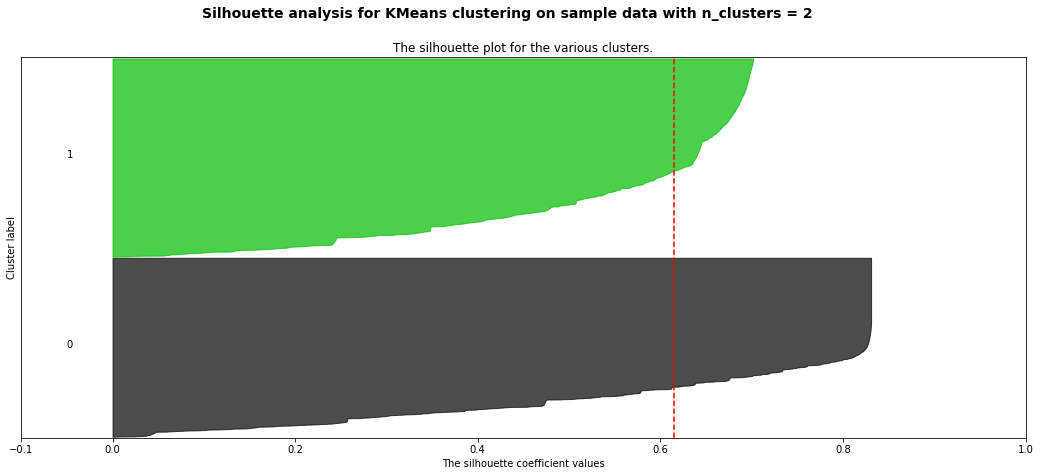

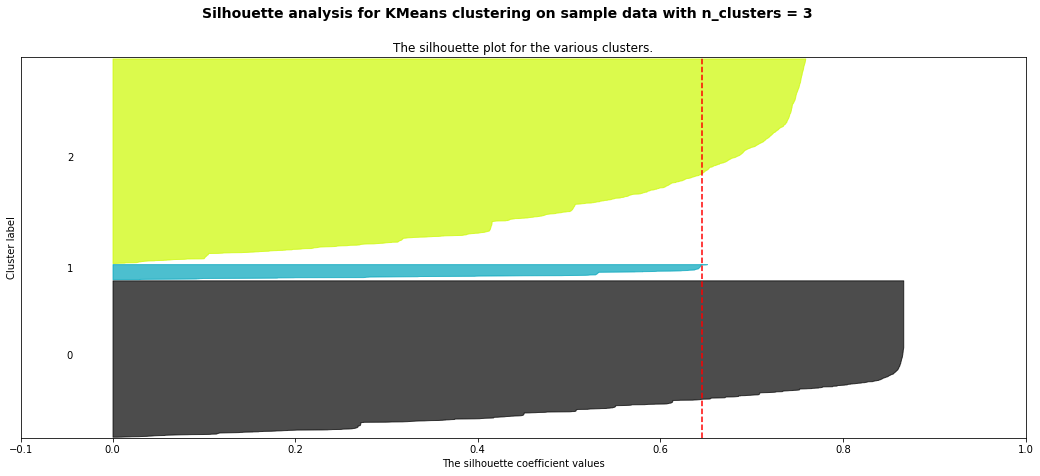

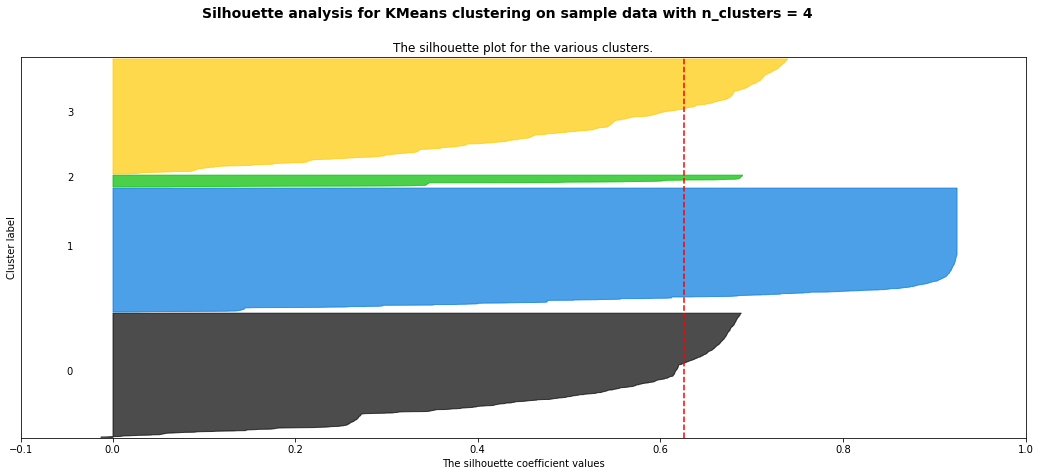

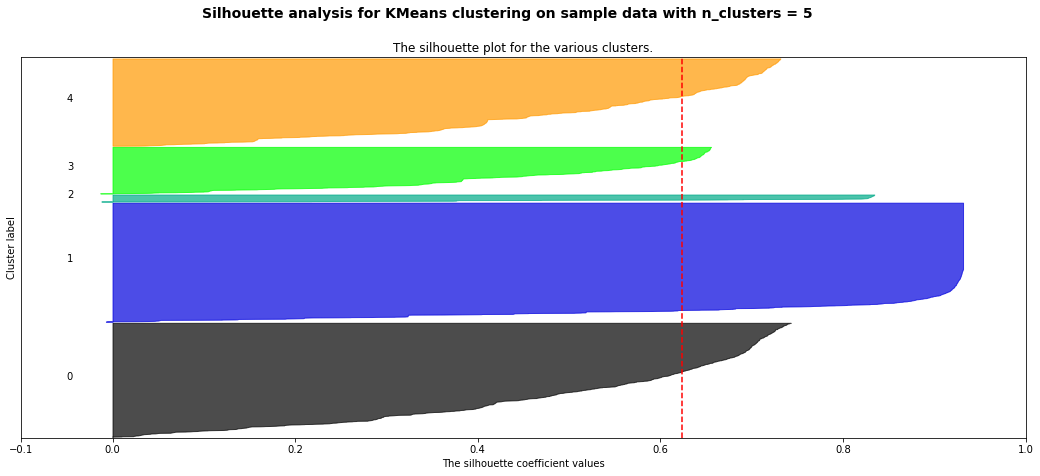

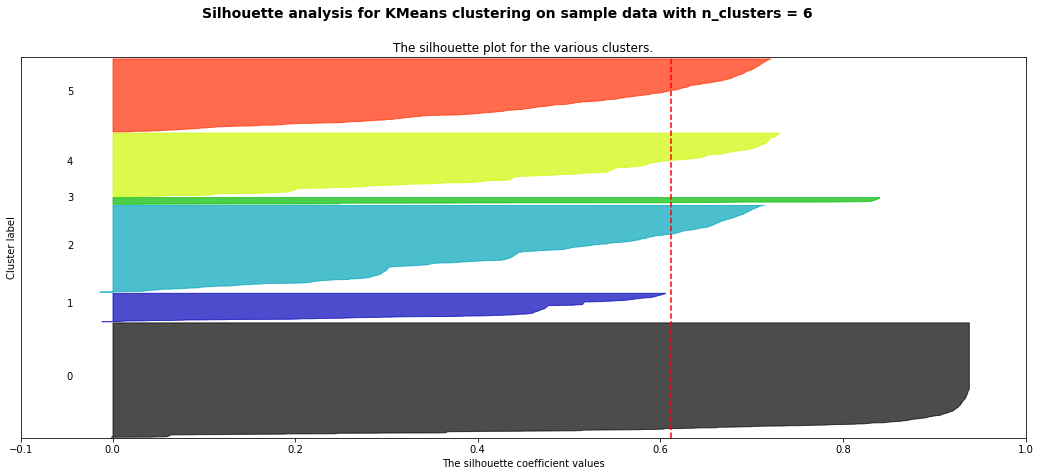

In [5]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
df1 = striker_df(2)
df1.fillna(0, inplace = True)
df1.drop(index = list(df1[df1['np:G-xG'].isin([np.inf])].index), inplace = True)
df1.drop(index = list(df1[df1['npxG/90'].isin([np.inf])].index), inplace = True)
cols = ['Gls/90', 'Sh/90', 'SoT/90', 'SoT%', 'npxG/90', 'np:G-xG/90']
X = df1[cols]

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In [6]:
def cluster(df):
    df.drop(index = list(df[df['npxG/90'].isin([np.inf])].index), inplace = True)
    cols = ['Gls/90', 'Sh/90', 'SoT/90', 'SoT%', 'npxG/90', 'np:G-xG/90']
    from sklearn.cluster import KMeans
    kmeans = KMeans(n_clusters = 3)
    kmeans.fit(df[cols])
    y_k = kmeans.fit_predict(df[cols])
    df['cluster'] = y_k
    return df

In [7]:
def get_similar_players(x, name, n_players = 5, games_played = 30, max_age = 50):
    from sklearn.neighbors import DistanceMetric
    dist = DistanceMetric.get_metric('euclidean')
    name = name
    d = {}
    cols = ['Gls/90', 'Sh/90', 'SoT/90', 'SoT%', 'npxG/90', 'np:G-xG/90']
    X1 = x[x['Player'] == name][cols]
    y = x[(x['90s'] >= games_played) & (x['Age'] <= max_age)]
    l1 = X1.values.tolist()[0]
    for id in y.index:
        if y.loc[id, 'Player'] != name:
            l2 = y.loc[id, cols].values.tolist()
            X = [l1,l2]
            d[id] = dist.pairwise(X)[1][0]
    l_similar_idx = sorted(d, key = d.get)[:n_players]
    playas = y[y.index.isin(l_similar_idx)]
    return playas

## `Testing`

In [8]:
df1 = striker_df(2)


In [9]:
df1

,Player,Nation,Pos,Squad,Comp,Age,90s,Gls,Sh/90,SoT/90,SoT%,npxG,np:G-xG,Gls/90,npxG/90,np:G-xG/90
0,Aaron Connolly,IRL,Forward,Brighton,Premier League,21,19.3,4,2.130000,0.606667,23.200000,7.5,-3.5,0.207254,0.388601,-0.181347
1,Aaron Cresswell,ENG,Defender,West Ham,Premier League,31,100.7,2,0.556667,0.106667,19.633333,2.9,-0.9,0.019861,0.028798,-0.008937
2,Aaron Hickey,SCO,Defender,Bologna,Serie A,19,48.1,5,0.463333,0.216667,42.833333,1.3,3.7,0.103950,0.027027,0.076923
3,Aaron Lennon,ENG,Midfielder,Burnley,Premier League,34,17.2,2,0.700000,0.230000,33.300000,1.1,0.9,0.116279,0.063953,0.052326
4,Aaron Leya Iseka,BEL,Forward,Metz,Ligue 1,22,22.4,8,1.610000,0.540000,33.300000,4.8,-0.8,0.357143,0.214286,-0.035714
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3552,Łukasz Fabiański,POL,Goalkeeper,West Ham,Premier League,36,107.0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3553,Łukasz Piszczek,POL,Defender,Dortmund,Bundesliga,35,10.2,0,0.200000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3554,Łukasz Skorupski,POL,Goalkeeper,Bologna,Serie A,30,92.0,0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000
3555,Šime Vrsaljko,CRO,Defender,Atlético Madrid,La Liga,29,21.8,1,0.130000,0.033333,8.333333,0.8,0.2,0.045872,0.036697,0.009174


In [10]:
df1 = cluster(df1)
df1.sample(5)

,Player,Nation,Pos,Squad,Comp,Age,90s,Gls,Sh/90,SoT/90,SoT%,npxG,np:G-xG,Gls/90,npxG/90,np:G-xG/90,cluster
962,Falaye Sacko,MLI,Defender,Saint-Étienne,Ligue 1,26,7.4,0,0.13,0.000000,0.0,0.1,-0.1,0.000000,0.013514,-0.013514,0
2622,Paolo Bartolomei,ITA,Midfielder,Spezia,Serie A,30,7.2,0,1.13,0.000000,0.0,0.4,-0.4,0.000000,0.055556,-0.055556,0
2637,Pathé Ciss,SEN,Midfielder,Rayo Vallecano,La Liga,27,12.2,2,1.64,0.410000,25.0,1.6,0.4,0.163934,0.131148,0.032787,1
2042,Luke Shaw,ENG,Defender,Manchester Utd,Premier League,26,76.8,2,0.36,0.153333,41.9,1.6,0.4,0.026042,0.020833,0.005208,1
2234,Mato Jajalo,BIH,Midfielder,Udinese,Serie A,33,7.8,0,0.24,0.000000,0.0,0.5,-0.5,0.000000,0.064103,-0.064103,0


In [11]:
get_similar_players(df1, 'Kylian Mbappé', n_players = 10, games_played = 30, max_age = 25)

,Player,Nation,Pos,Squad,Comp,Age,90s,Gls,Sh/90,SoT/90,SoT%,npxG,np:G-xG,Gls/90,npxG/90,np:G-xG/90,cluster
240,André Silva,POR,Forward,RB Leipzig,Bundesliga,25,84.5,67,3.106667,1.486667,47.200000,48.1,1.9,0.792899,0.569231,0.022485,1
272,Anthony Martial,FRA,Forward,Manchester Utd,Premier League,25,40.6,9,2.157500,0.990000,45.125000,13.7,-4.7,0.221675,0.337438,-0.115764,1
444,Breel Embolo,SUI,Attacking-Midfielder,M'Gladbach,Bundesliga,24,56.1,19,2.370000,1.113333,46.833333,22.8,-3.8,0.338681,0.406417,-0.067736,1
560,Christopher Nkunku,FRA,Attacking-Midfielder,RB Leipzig,Bundesliga,23,72.3,32,2.653333,1.256667,47.200000,29.7,1.3,0.442600,0.410788,0.017981,1
669,Daniele Verde,ITA,Attacking-Midfielder,Spezia,Serie A,25,43.5,20,2.906667,1.333333,45.600000,10.8,8.2,0.459770,0.248276,0.188506,1
1139,Giacomo Raspadori,ITA,Attacking-Midfielder,Sassuolo,Serie A,21,57.8,22,1.906667,0.860000,46.366667,15.9,6.1,0.380623,0.275087,0.105536,1
2579,Ollie Watkins,ENG,Forward,Aston Villa,Premier League,25,106.8,39,2.550000,1.130000,44.033333,40.4,-4.4,0.365169,0.378277,-0.041199,1
2759,Rafael Leão,POR,Forward,Milan,Serie A,22,71.7,23,2.456667,1.063333,44.066667,20.5,2.5,0.320781,0.285914,0.034868,1
3084,Simon Banza,FRA,Forward,Lens,Ligue 1,24,31.8,11,3.023333,1.493333,44.433333,11.4,-2.4,0.345912,0.358491,-0.075472,1
3175,Taiwo Awoniyi,NGA,Forward,Union Berlin,Bundesliga,23,54.4,25,2.190000,0.986667,45.033333,26.2,-3.2,0.459559,0.481618,-0.058824,1
